In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost

In [146]:
df = pd.read_csv("../data/final_data.csv")
df = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33509 entries, 0 to 33508
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   33509 non-null  int64  
 1   author               28485 non-null  object 
 2   geometry             28009 non-null  object 
 3   pressure [MPa]       33509 non-null  float64
 4   mass_flux [kg/m2-s]  33509 non-null  float64
 5   x_e_out [-]          23094 non-null  float64
 6   D_e [mm]             33509 non-null  float64
 7   D_h [mm]             33509 non-null  float64
 8   length [mm]          33509 non-null  float64
 9   chf_exp [MW/m2]      33509 non-null  float64
 10  geometry_corrected   30254 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 2.8+ MB


In [147]:
# df = pd.read_csv("../data/data.csv")
# df["D_h [mm]"] = df["D_h [mm]"].fillna(df["D_h [mm]"].mean())
# df["D_e [mm]"] = df["D_e [mm]"].fillna(df["D_h [mm]"].mean())
# df["pressure [MPa]"] = df["pressure [MPa]"].fillna(df["pressure [MPa]"].mean())
# df["length [mm]"] = df["length [mm]"].fillna(df["length [mm]"].mean())
# df["mass_flux [kg/m2-s]"] = df["mass_flux [kg/m2-s]"].fillna(df["mass_flux [kg/m2-s]"].mean())


### Target

In [148]:
# target = df[df["x_e_out [-]"].isnull()]
# target = target[["D_e [mm]", "D_h [mm]", "pressure [MPa]", "chf_exp [MW/m2]", "length [mm]", "mass_flux [kg/m2-s]"]]
# target.info()

### Training data

In [149]:
X = df[df["x_e_out [-]"].notna()]
X = X[["D_e [mm]", "D_h [mm]", "pressure [MPa]", "chf_exp [MW/m2]", "length [mm]", "mass_flux [kg/m2-s]"]]
y = df[df["x_e_out [-]"].notna()]
y = y["x_e_out [-]"]

In [150]:
X = X.rename(columns={"D_e [mm]":"De","D_h [mm]":"Dh","pressure [MPa]":"pressure","chf_exp [MW/m2]":"chfExp","length [mm]":"length","mass_flux [kg/m2-s]":"massFlux"})


In [151]:
X.shape, y.shape

((23094, 6), (23094,))

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [153]:
rand_forest = RandomForestRegressor(random_state=42)

gbr_reg = GradientBoostingRegressor()

xgb_reg = xgboost.XGBRegressor()

# Definimos sus hiperparametros

rand_forest_param = {
    'n_estimators': [10,50, 100],
    'min_samples_leaf': [2, 4, 6, 10],
    'max_features': [1, 2, 3, 4, 5, 6]
    }

gbr_param = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.5, 0.2, 0.1, 1],
    'max_depth': [3, 5, 7, 10]}

xgb_reg_param = {
    'n_estimators': [10, 50, 100],
    
    'learning_rate':[1, 0.1, 0.05, 0.01],
    'min_child_weight':[2,3,5],
    'max_depth': [3, 5, 7],
    'alpha':[0.01, 1, 5],
}



# GridSearch

gs_rand_forest = GridSearchCV(rand_forest,
                            rand_forest_param,
                            cv=10,
                            scoring=["neg_mean_squared_error", "r2"],
                            verbose=1,
                            n_jobs=-1,refit="neg_mean_squared_error")

gs_xgb = GridSearchCV(xgb_reg,
                        xgb_reg_param,
                        cv=10,
                        scoring=["neg_mean_squared_error", "r2"],
                        verbose=1,
                        n_jobs=-1,refit="neg_mean_squared_error")


gs_gbr = GridSearchCV(gbr_reg,
                        gbr_param,
                        cv=10,
                        scoring=["neg_mean_squared_error", "r2"],
                        verbose=1,
                        n_jobs=-1,
                        refit="neg_mean_squared_error")

grids = {"gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb,
         "gs_gbr":gs_gbr,
         }

In [154]:
%%time

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
CPU times: total: 23 s
Wall time: 4min 13s


In [155]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
0,gs_rand_forest,-0.005310
1,gs_xgb,-0.005355
2,gs_gbr,-0.005498


In [156]:
# voting_reg = Pipeline(steps=[("scaler",StandardScaler()),
#                           ("voting_reg",VotingRegressor())
#                          ])

# voting_reg_param = {
#     'gbr_reg__n_estimators': [100, 200, 300],
#     'gbr_reg__learning_rate': [0.01, 0.1, 1],
#     'gbr_reg__max_depth': [3, 5, 7]}

# gs_voting_reg = GridSearchCV(rand_forest,
#                             rand_forest_param,
#                             cv=10,
#                             scoring=["neg_mean_squared_error", "r2"],
#                             verbose=1,
#                             n_jobs=-1,refit="neg_mean_squared_error")

In [157]:
# El mejor modelo ha sido
best_model = grids["gs_xgb"]
mejor_modelo = best_model.best_estimator_
mejor_modelo.fit(X_train, y_train)
mejor_modelo.score(X_test, y_test)

0.48903108089062064

In [158]:
best_model = gs_rand_forest.best_estimator_
best_model.feature_importances_

array([0.13258299, 0.09378066, 0.18550601, 0.36090429, 0.11851925,
       0.1087068 ])

In [172]:
best_model = pd.DataFrame(gs_xgb.cv_results_)
model_ranking = best_model[["params", "rank_test_r2", "rank_test_neg_mean_squared_error", "mean_test_neg_mean_squared_error"]].sort_values(by="rank_test_r2")
model_ranking
# model_ranking.loc[155, "params"]

,params,rank_test_r2,rank_test_neg_mean_squared_error,mean_test_neg_mean_squared_error
155,"{'alpha': 1, 'learning_rate': 0.1, 'max_depth'...",1,1,-0.006169
158,"{'alpha': 1, 'learning_rate': 0.1, 'max_depth'...",2,2,-0.006172
161,"{'alpha': 1, 'learning_rate': 0.1, 'max_depth'...",3,3,-0.006176
146,"{'alpha': 1, 'learning_rate': 0.1, 'max_depth'...",4,4,-0.006189
149,"{'alpha': 1, 'learning_rate': 0.1, 'max_depth'...",5,5,-0.006190
...,...,...,...,...
297,"{'alpha': 5, 'learning_rate': 0.01, 'max_depth...",316,316,-0.213957
318,"{'alpha': 5, 'learning_rate': 0.01, 'max_depth...",316,316,-0.213957
306,"{'alpha': 5, 'learning_rate': 0.01, 'max_depth...",316,316,-0.213957
300,"{'alpha': 5, 'learning_rate': 0.01, 'max_depth...",316,316,-0.213957


### Second try

In [161]:
X_2 = df[df["x_e_out [-]"].notna()]

X_2 = X_2[["pressure [MPa]", "chf_exp [MW/m2]"]]
X_2 = X_2.rename(columns={"pressure [MPa]":"pressure","chf_exp [MW/m2]":"chfExp"})
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.2, random_state=2)



In [162]:
%%time

for nombre, grid_search in grids.items():
    grid_search.fit(X_train_2, y_train_2)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
CPU times: total: 12 s
Wall time: 2min 10s


In [163]:
# El mejor modelo ha sido
best_model = grids["gs_rand_forest"]
mejor_modelo = best_model.best_estimator_
mejor_modelo.fit(X_train_2, y_train_2)
mejor_modelo.score(X_test_2, y_test_2)

0.39257149908419176

In [167]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
1,gs_xgb,-0.006169
0,gs_rand_forest,-0.006209
2,gs_gbr,-0.006267


In [171]:
best_model = pd.DataFrame(gs_xgb.cv_results_)
model_ranking = best_model[["params", "rank_test_r2", "rank_test_neg_mean_squared_error", "mean_test_neg_mean_squared_error"]].sort_values(by="rank_test_r2")
# model_ranking
model_ranking.loc[155, "params"]

{'alpha': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 2,
 'n_estimators': 100}

### Train first model

In [173]:
model_2 = xgboost.XGBRegressor(alpha=1, learning_rate = 0.1, max_depth=7, min_child_weight = 2, n_estimators=100)

model_2.fit(X, y)

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

### Deep Learning time

In [180]:
X_train_n, X_valid, y_train_n, y_valid = train_test_split(X_train,
                                                      y_train)

In [181]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [182]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [194]:
capas = [
    keras.layers.Dense(50, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1)
]
model = keras.models.Sequential(capas)

In [195]:
model.compile(optimizer="adam",
              loss="mean_squared_error",
            #   metrics=["mse"]
            )

In [196]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_valid, y_valid)
)

Epoch 1/3
289/289 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0093
Epoch 2/3
289/289 [==============================] - 0s 823us/step - loss: 0.0136 - val_loss: 0.0089
Epoch 3/3
289/289 [==============================] - 0s 820us/step - loss: 0.0105 - val_loss: 0.0084


In [197]:
model.evaluate(X_valid, y_valid)

145/145 [==============================] - 0s 478us/step - loss: 0.0084


0.008381238207221031

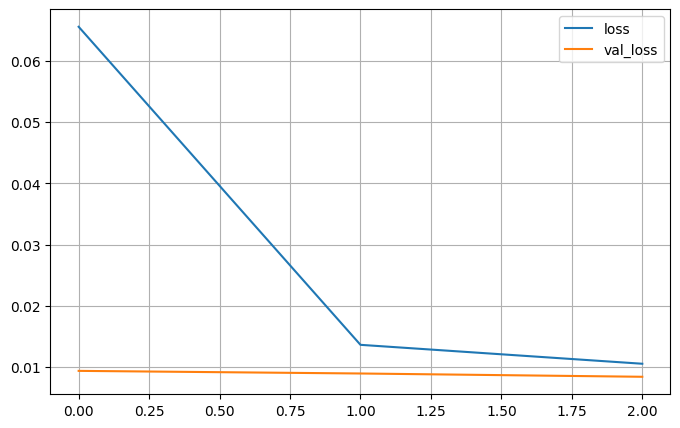

In [198]:

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [188]:
model.save("../utils/ANN_heat.h5")

## Submission time

In [81]:
def generate_submission_file(model, X, submission_number):
    df_test = pd.read_csv('../data/target.csv', sep=",")
    y = model.predict(X)
    y = y.reshape(-1)
    df_test["y_test"] = y
    df_sub = pd.DataFrame({'Id': df_test['id'].values.reshape(-1), 'x_e_out [-]': y})
    df_sub.to_csv(f"../submissions/submission_{submission_number}.csv", index=False)

In [82]:
final_target = df.copy()
final_target = final_target[final_target["x_e_out [-]"].isnull()]

final_target = final_target[["D_e [mm]", "D_h [mm]", "pressure [MPa]", "chf_exp [MW/m2]", "length [mm]", "mass_flux [kg/m2-s]"]]
final_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10415 entries, 4 to 31642
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   D_e [mm]             10415 non-null  float64
 1   D_h [mm]             10415 non-null  float64
 2   pressure [MPa]       10415 non-null  float64
 3   chf_exp [MW/m2]      10415 non-null  float64
 4   length [mm]          10415 non-null  float64
 5   mass_flux [kg/m2-s]  10415 non-null  float64
dtypes: float64(6)
memory usage: 569.6 KB


In [178]:
final_target = final_target.rename(columns={"D_e [mm]":"De","D_h [mm]":"Dh","pressure [MPa]":"pressure","chf_exp [MW/m2]":"chfExp","length [mm]":"length","mass_flux [kg/m2-s]":"massFlux"})

In [179]:
generate_submission_file(model_2, final_target, 2)